In [36]:
from loader import list_files, Files, Folders  #precalculate what we are loading in
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sys import getsizeof
from data_xml import Loader
import matplotlib.cm as cm

In [5]:
class loaded:
    def __init__(self):
        data = np.load("/its/home/drs25/Documents/data/Tactile Dataset/Directions/directions_X_data_wool.npz") #load data
        for array_name in data:
            self.X=data[array_name].astype(np.int8)
        data = np.load("/its/home/drs25/Documents/data/Tactile Dataset/Directions/directions_y_data_wool.npz") #load data
        for array_name in data:
            self.y=data[array_name].astype(np.int8)
        self.keys={}
        files=['wool', 'LacedMatt', 'Gfoam', 'bubble', 'Efoam', 'cotton', 'Flat', 'felt', 'Ffoam']
        for i, name in enumerate(files):
            self.keys[i]=name
        print("Dataset size:",self.X.shape[0],"\nWindow size:",self.X.shape[1],"\nImage:",self.X.shape[2:])
        print("Memory needed:",round(getsizeof(self.X)/ 1024 / 1024/ 1024,2),"GB")
        assert self.X.shape[0]==self.y.shape[0],"Incorrect data size match y="+str(self.y.shape[0])+" x="+str(self.X.shape[0])
        #randomize order
        n_samples = self.X.shape[0]
        indices = np.random.permutation(n_samples)
        shuffled_data = self.X[indices]
        shuffled_labels = self.y[indices]
        self.X=shuffled_data
        self.y=shuffled_labels
    def applySobel(self):
        for i in range(len(self.X)): #crop all images individually
            for j in range(len(self.X[0])):
                image=self.X[i][j]
                # Apply Sobel filter in x-direction
                sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # ksize=3 for a 3x3 Sobel kernel

                # Apply Sobel filter in y-direction
                sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)

                # Convert the results back to uint8
                sobel_x = np.uint8(np.absolute(sobel_x))
                sobel_y = np.uint8(np.absolute(sobel_y))

                # Combine the results to get the final edge-detected image
                sobel_combined = cv2.bitwise_or(sobel_x, sobel_y)
                self.X[i][j]=sobel_combined

data=loaded()

Dataset size: 2761 
Window size: 20 
Image: (110, 120)
Memory needed: 0.68 GB


array([82, 81,  0,  0], dtype=int8)

3
(3, 20)
2
(2, 20)
3
(3, 20)
3
(3, 20)


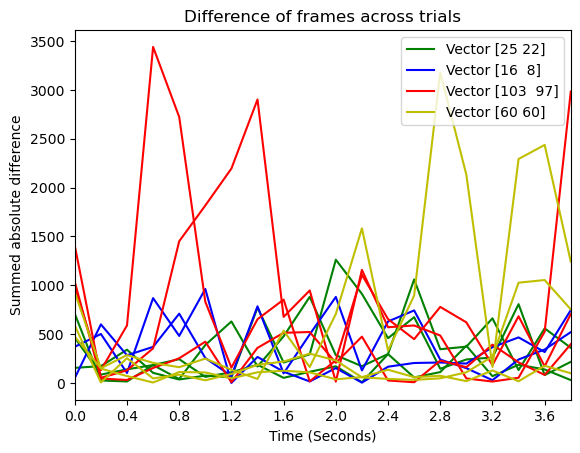

In [44]:
sample=[data.y[np.random.randint(0,100)][0:2] for i in range(4)]
colours=["g","b","r","y"]
for k in range(len(sample)):
    frames=[]
    count=0
    for i in range(len(data.y)):
        if data.y[i][0]==sample[k][0] and data.y[i][1]==sample[k][1]:
            count+=1
            frames.append(i)
    print(count)

    change=[]
    for i in range(len(frames)):
        y=data.y[frames[i]]
        framesA=data.X[frames[i]][0:-2].reshape(data.X[frames[i]].shape[0], -1)
        framesB=data.X[frames[i]][1:-1].reshape(data.X[frames[i]].shape[0], -1)
        difference=np.abs(np.sum(framesA-framesB,axis=1))
        change.append(difference)


    change=change=np.array(change)
    print(change.shape)

    for i in range(len(change)):
        if i==0:
            plt.plot(change[i],c=colours[k],label="Vector "+str(sample[k]))
        else:
            plt.plot(change[i],c=colours[k])

plt.legend(loc="upper right")
plt.xticks([i for i in range(0,len(change[1]),int(len(data.X[0])*0.1))], labels=[round((4/len(data.X[0]))*i,2) for i in range(0,len(change[2]),int(len(data.X[0])*0.1))])
plt.xlabel("Time (Seconds)")
plt.xlim([0,19])
plt.ylabel("Summed absolute difference")
plt.title("Difference of frames across trials")
plt.show()

(2761,)


/tmp/ipykernel_4279/323634391.py:28: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Value of X')


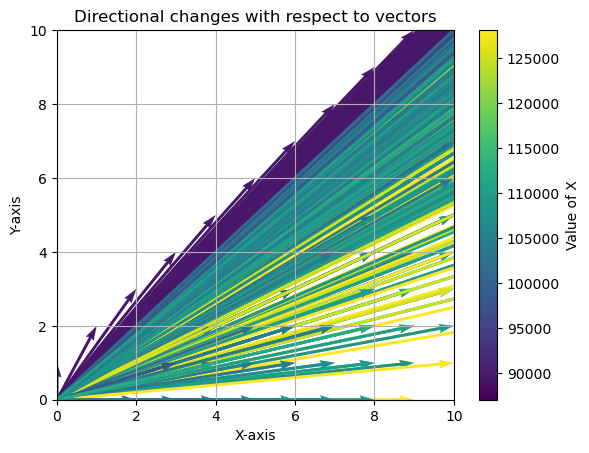

In [48]:
#visualize the vectors 
X=[]
for i in range(len(data.X)):
    y=data.y[i]
    framesA=data.X[i][0:-2].reshape(data.X[i].shape[0], -1)
    framesB=data.X[i][1:-1].reshape(data.X[i].shape[0], -1)
    difference=(np.sum(np.abs(framesA-framesB)))
    X.append(difference)

X=np.array(X)
print(X.shape)
norm = plt.Normalize(X.min(), X.max())
cmap = cm.viridis

origin=np.zeros((len(data.y),2))
for i in range(len(data.y)):
    plt.quiver(origin[i, 0], origin[i, 1], data.y[i, 0], data.y[i, 1], angles='xy', scale_units='xy', scale=1, color=cmap(norm(X[i])))
    
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid()    
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.xlim([0, 10])
plt.ylim([0, 10])
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label='Value of X')
plt.title("Directional changes with respect to vectors")
plt.show()